In [1]:
# Standard imports
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import logging

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Progress tracking
from tqdm import tqdm

# Set device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seed for reproducibility
seed = 1

def seed_torch(seed):
    """
    Set random seed for reproducibility across various libraries.
    """
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

# Apply seed
np.random.seed(seed)
random.seed(seed)
seed_torch(seed)


Using device: cpu


2025-01-03 13:27:49,124 - INFO - Loading data from C:\Users\matay\Desktop\DL Project\dataset\File_Names.xlsx
2025-01-03 13:27:49,459 - INFO - Extracting group numbers from filenames.
Processing Images: 100%|██████████| 2416/2416 [00:27<00:00, 87.45it/s] 
2025-01-03 13:28:17,092 - INFO - Image processing complete.


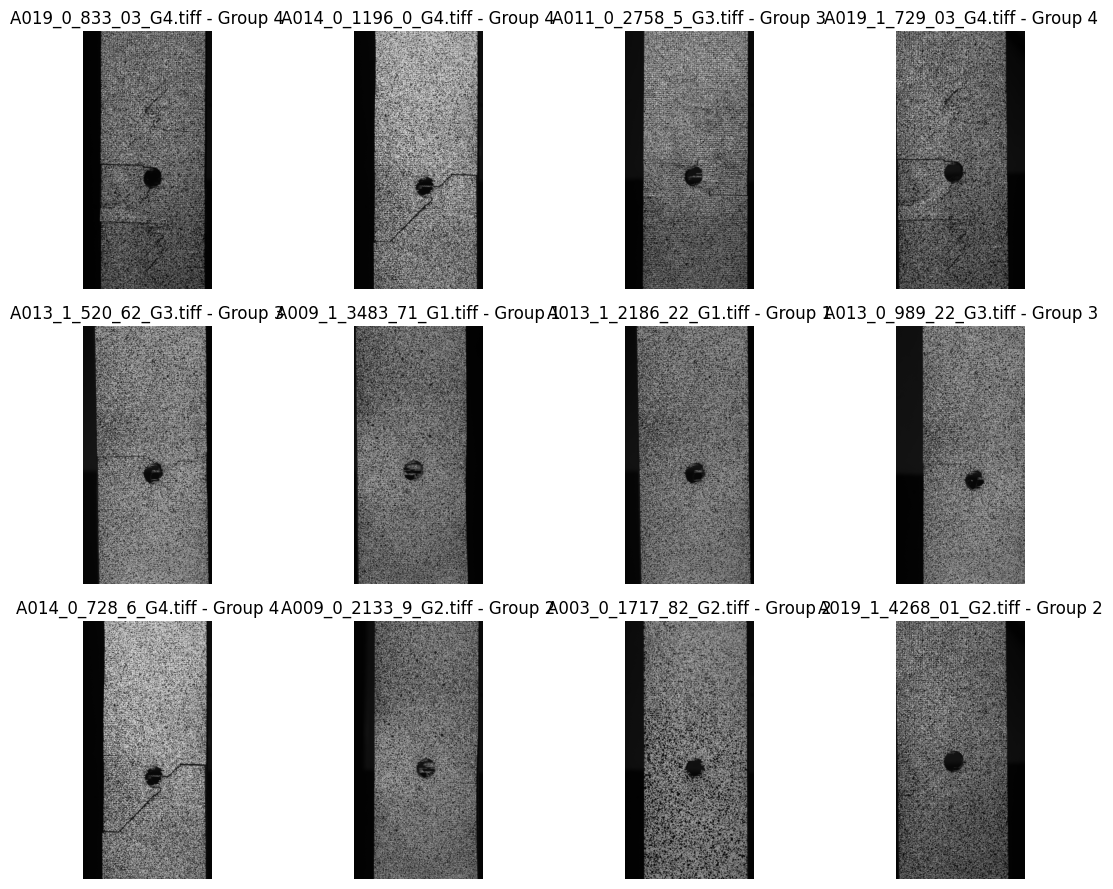

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Function to load data from an Excel file
def load_data(file_path):
    """
    Load data from an Excel file.

    Args:
        file_path (str): Path to the Excel file.

    Returns:
        pd.DataFrame: Loaded dataframe.
    """
    if not os.path.exists(file_path):
        logging.error(f"Excel file not found: {file_path}")
        raise FileNotFoundError(f"Excel file not found: {file_path}")
    logging.info(f"Loading data from {file_path}")
    return pd.read_excel(file_path, header=0)

# Function to process images and append pixel arrays to the dataframe
def process_images(dataframe, images_dir, filename_column):
    """
    Process images from a directory and append their pixel arrays to the dataframe.

    Args:
        dataframe (pd.DataFrame): Dataframe containing image filenames.
        images_dir (str): Directory containing images.
        filename_column (str): Column name in dataframe with filenames.

    Returns:
        pd.DataFrame: Dataframe with an added 'pixel_array' column.
    """
    pixel_arrays = []

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Processing Images"):
        filename = row[filename_column]
        image_path = os.path.join(images_dir, filename)

        if not os.path.exists(image_path):
            logging.warning(f"Image file not found: {image_path}. Skipping.")
            pixel_arrays.append(None)
            continue

        try:
            # Open the image and convert to grayscale
            image = Image.open(image_path).convert('L')
            pixel_arrays.append(np.array(image))
        except Exception as e:
            logging.error(f"Error processing {filename}: {e}")
            pixel_arrays.append(None)

    dataframe['pixel_array'] = pixel_arrays
    logging.info("Image processing complete.")
    return dataframe

# Paths (replace with dynamic inputs or configuration settings)
excel_path = r"C:\Users\matay\Desktop\DL Project\dataset\File_Names.xlsx"
images_dir = r"C:\Users\matay\Desktop\DL Project\dataset\ALL"

# Load the DataFrame
try:
    pic_list = load_data(excel_path)
except FileNotFoundError as e:
    logging.error("Exiting due to missing input files.")
    exit()

# Validate the existence of the filename column
filename_column = 'File Names'
if filename_column not in pic_list.columns:
    logging.error(f"Column '{filename_column}' not found in the dataset. Exiting.")
    exit()

# Extract group numbers from filenames
logging.info("Extracting group numbers from filenames.")
pic_list['Group_Number'] = pic_list[filename_column].str.extract(r'_G(\d)\.tiff$', expand=False)

# Process images and add pixel arrays
pic_df = process_images(pic_list, images_dir, filename_column)

# Function to visualize images
def visualize_images(dataframe, num_images=12):
    """
    Visualize a random selection of images from the dataframe.

    Args:
        dataframe (pd.DataFrame): Dataframe containing image pixel arrays.
        num_images (int): Number of images to display.
    """
    valid_images = dataframe.dropna(subset=['pixel_array'])
    if valid_images.empty:
        logging.error("No valid images to display.")
        return

    random_indices = np.random.choice(valid_images.index, min(num_images, len(valid_images)), replace=False)
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        ax = axes[i]
        image = valid_images.loc[idx, 'pixel_array']
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{valid_images.loc[idx, filename_column]} - Group {valid_images.loc[idx, 'Group_Number']}")
        ax.axis('off')

    # Remove any unused axes
    for ax in axes[len(random_indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the processed images
visualize_images(pic_df)


In [3]:
# Convert 'Group_Number' to integer labels starting from 0
pic_df['Group_Number'] = pic_df['Group_Number'].astype(int) - 1

# Define the target image size for resizing
IMAGE_SIZE = (256, 256)

# Function to preprocess images
def preprocess_image(image_array):
    """
    Preprocesses an image: applies resizing, normalization, and adds a channel dimension.

    Args:
        image_array (np.ndarray): Input image as a 2D NumPy array (grayscale).

    Returns:
        np.ndarray: Preprocessed image as a 3D NumPy array (1, H, W).
    """
    if image_array is None:
        return None
    
    # Resize the image
    image = Image.fromarray(image_array)
    image = image.resize(IMAGE_SIZE)
    
    # Normalize pixel values to [0, 1]
    image_array = np.array(image) / 255.0
    
    # Add channel dimension for PyTorch compatibility (1, H, W)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Apply preprocessing to all images in the dataframe
logging.info("Preprocessing images.")
pic_df['processed_image'] = pic_df['pixel_array'].apply(preprocess_image)

# Extract features (X) and labels (y) from the dataframe
logging.info("Extracting features and labels.")
X = np.stack(pic_df.dropna(subset=['processed_image'])['processed_image'].values)
y = pic_df.dropna(subset=['processed_image'])['Group_Number'].values

# Split the dataset into training, validation, and test sets
logging.info("Splitting the dataset into training, validation, and test sets.")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# Convert NumPy arrays to PyTorch tensors
logging.info("Converting data to PyTorch tensors.")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

logging.info("Data preprocessing and splitting complete.")


2025-01-03 13:28:18,625 - INFO - Preprocessing images.
2025-01-03 13:28:26,482 - INFO - Extracting features and labels.
2025-01-03 13:28:26,696 - INFO - Splitting the dataset into training, validation, and test sets.
2025-01-03 13:28:26,967 - INFO - Converting data to PyTorch tensors.
2025-01-03 13:28:27,034 - INFO - Data preprocessing and splitting complete.


In [4]:
# Define Dataset class for PyTorch
class ImageDataset(Dataset):
    """
    Custom Dataset for handling images and their labels.

    Args:
        images (torch.Tensor): Tensor of preprocessed images.
        labels (torch.Tensor): Tensor of corresponding labels.
    """
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample (image and label) by index.

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Image tensor and label tensor.
        """
        return self.images[idx], self.labels[idx]

# Create datasets for training, validation, and testing
logging.info("Creating datasets.")
train_dataset = ImageDataset(X_train_tensor, y_train_tensor)
val_dataset = ImageDataset(X_val_tensor, y_val_tensor)
test_dataset = ImageDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for efficient batching and shuffling
logging.info("Creating DataLoaders.")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

logging.info("DataLoaders created successfully.")


2025-01-03 13:28:27,051 - INFO - Creating datasets.
2025-01-03 13:28:27,058 - INFO - Creating DataLoaders.
2025-01-03 13:28:27,059 - INFO - DataLoaders created successfully.


In [5]:
# Define the CNN Model
class CNNModel(nn.Module):
    """
    Convolutional Neural Network (CNN) for image classification.

    Args:
        num_classes (int): Number of output classes.
    """
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            # Input: (1, 256, 256)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Output: (16, 256, 256)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # Output: (16, 128, 128)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # Output: (32, 64, 64)
            nn.Dropout(0.3),

            nn.Conv2d(32, 48, kernel_size=3, padding=1), # Output: (48, 64, 64)
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # Output: (48, 32, 32)

            nn.Conv2d(48, 64, kernel_size=3, padding=1), # Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                           # Output: (64, 16, 16)
        )

        # Fully connected layers
        self.flattened_size = None  # Placeholder for dynamically calculated size
        self.fc1 = None  # Placeholder, dynamically set in forward pass
        self.dropout = nn.Dropout(0.4)  # High dropout rate to prevent overfitting
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        # Pass through feature extractor
        x = self.feature_extractor(x)  # Output: (64, 16, 16)
        x = x.view(x.size(0), -1)      # Flatten: (batch_size, 64 * 16 * 16 = 16384)

        # Dynamically initialize fc1 based on the flattened size
        if self.flattened_size is None:
            self.flattened_size = x.size(1)  # Calculate flattened size (16384)
            self.fc1 = nn.Linear(self.flattened_size, 512)
            self.fc1.to(x.device)  # Ensure it's on the correct device

        # Fully connected layers
        x = F.relu(self.fc1(x))       # Output: (batch_size, 512)
        x = self.dropout(x)
        x = self.fc2(x)               # Output: (batch_size, num_classes)
        return x


In [6]:
# Instantiate the model
model = CNNModel(num_classes=4).to(device)

# Print the size of the model layers
def print_model_summary(model, input_size=(1, 256, 256)):
    """
    Print the size of each layer in the model.

    Args:
        model (nn.Module): The PyTorch model.
        input_size (tuple): Size of a single input example (C, H, W).
    """
    print("Model Summary:")
    print("=" * 50)
    dummy_input = torch.randn(1, *input_size).to(device)
    hooks = []

    def register_hook(module):
        def hook(module, input, output):
            class_name = module.__class__.__name__
            module_idx = len(hooks)
            m_key = f"{class_name}-{module_idx + 1}"
            print(f"{m_key:30s} | Output shape: {str(output.shape):30s}")
        hooks.append(module.register_forward_hook(hook))

    model.apply(register_hook)
    model(dummy_input)
    for hook in hooks:
        hook.remove()
    print("=" * 50)

# Print the model summary
print_model_summary(model)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.9)

logging.info("Model, loss function, optimizer, and scheduler are initialized.")


2025-01-03 13:28:27,132 - INFO - Model, loss function, optimizer, and scheduler are initialized.


Model Summary:
Conv2d-22                      | Output shape: torch.Size([1, 16, 256, 256]) 
BatchNorm2d-22                 | Output shape: torch.Size([1, 16, 256, 256]) 
ReLU-22                        | Output shape: torch.Size([1, 16, 256, 256]) 
MaxPool2d-22                   | Output shape: torch.Size([1, 16, 128, 128]) 
Conv2d-22                      | Output shape: torch.Size([1, 32, 128, 128]) 
BatchNorm2d-22                 | Output shape: torch.Size([1, 32, 128, 128]) 
ReLU-22                        | Output shape: torch.Size([1, 32, 128, 128]) 
MaxPool2d-22                   | Output shape: torch.Size([1, 32, 64, 64])   
Dropout-22                     | Output shape: torch.Size([1, 32, 64, 64])   
Conv2d-22                      | Output shape: torch.Size([1, 48, 64, 64])   
BatchNorm2d-22                 | Output shape: torch.Size([1, 48, 64, 64])   
ReLU-22                        | Output shape: torch.Size([1, 48, 64, 64])   
MaxPool2d-22                   | Output shape: to

2025-01-03 13:28:57,656 - INFO - Epoch [1/60], Train Loss: 4.2007, Train Acc: 28.03%, Val Loss: 1.5140, Val Acc: 23.48%
2025-01-03 13:29:31,461 - INFO - Epoch [2/60], Train Loss: 1.3954, Train Acc: 35.25%, Val Loss: 1.3684, Val Acc: 24.86%
2025-01-03 13:30:03,493 - INFO - Epoch [3/60], Train Loss: 1.3034, Train Acc: 40.21%, Val Loss: 1.2934, Val Acc: 40.88%
2025-01-03 13:30:34,825 - INFO - Epoch [4/60], Train Loss: 1.2852, Train Acc: 41.22%, Val Loss: 1.2510, Val Acc: 42.82%
2025-01-03 13:31:06,885 - INFO - Epoch [5/60], Train Loss: 1.2697, Train Acc: 41.10%, Val Loss: 1.2339, Val Acc: 45.58%
2025-01-03 13:31:38,706 - INFO - Epoch [6/60], Train Loss: 1.2522, Train Acc: 43.11%, Val Loss: 1.2226, Val Acc: 51.66%
2025-01-03 13:32:12,248 - INFO - Epoch [7/60], Train Loss: 1.2265, Train Acc: 43.41%, Val Loss: 1.1979, Val Acc: 47.24%
2025-01-03 13:32:44,616 - INFO - Epoch [8/60], Train Loss: 1.2237, Train Acc: 45.18%, Val Loss: 1.1588, Val Acc: 55.52%
2025-01-03 13:33:18,112 - INFO - Epoch [

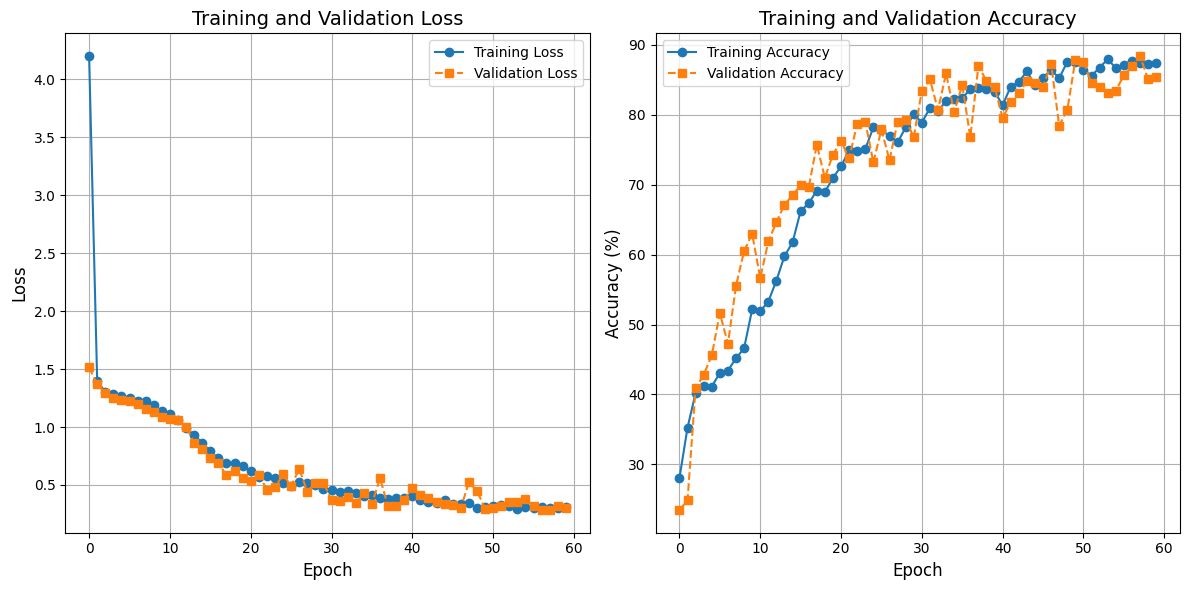

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=60):
    """
    Train and validate the model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Defaults to None.
        num_epochs (int): Number of epochs to train.

    Returns:
        None
    """
    train_loss, train_accuracy = [], []  # Track training loss and accuracy
    val_loss, val_accuracy = [], []  # Track validation loss and accuracy

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = 100 * correct / total
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * correct / total
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)

        # Step the learning rate scheduler, if applicable
        if scheduler:
            scheduler.step()

        logging.info(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%"
        )

    # Plot training and validation metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='s', linestyle='--')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(val_accuracy, label='Validation Accuracy', marker='s', linestyle='--')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Save and show plots
    plt.tight_layout()
    plt.savefig('training_validation_curves.png', dpi=300)
    plt.show()


# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler)


Test Accuracy: 87.88%


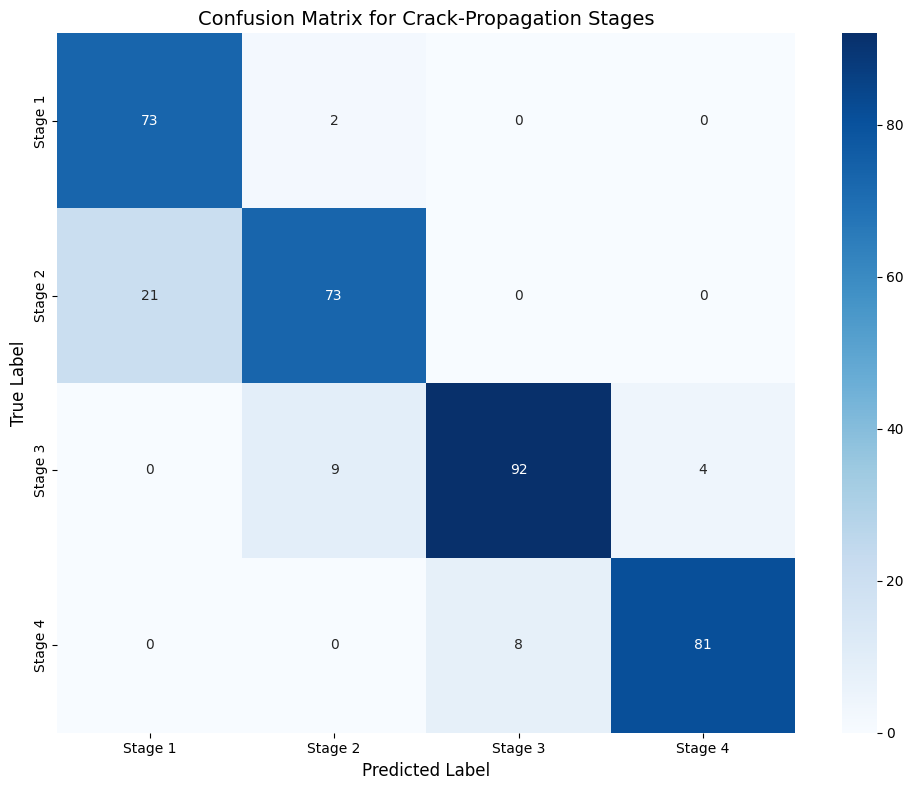


Classification Report:
              precision    recall  f1-score   support

     Stage 1       0.78      0.97      0.86        75
     Stage 2       0.87      0.78      0.82        94
     Stage 3       0.92      0.88      0.90       105
     Stage 4       0.95      0.91      0.93        89

    accuracy                           0.88       363
   macro avg       0.88      0.88      0.88       363
weighted avg       0.89      0.88      0.88       363



In [8]:
# Evaluation on test set
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set and generate performance metrics.

    Args:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test set.

    Returns:
        None
    """
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    # Evaluate the model
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # Calculate test accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']  # Update as per your classes

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=True,
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix for Crack-Propagation Stages', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save confusion matrix to file
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

# Evaluate the model
evaluate_model(model, test_loader)


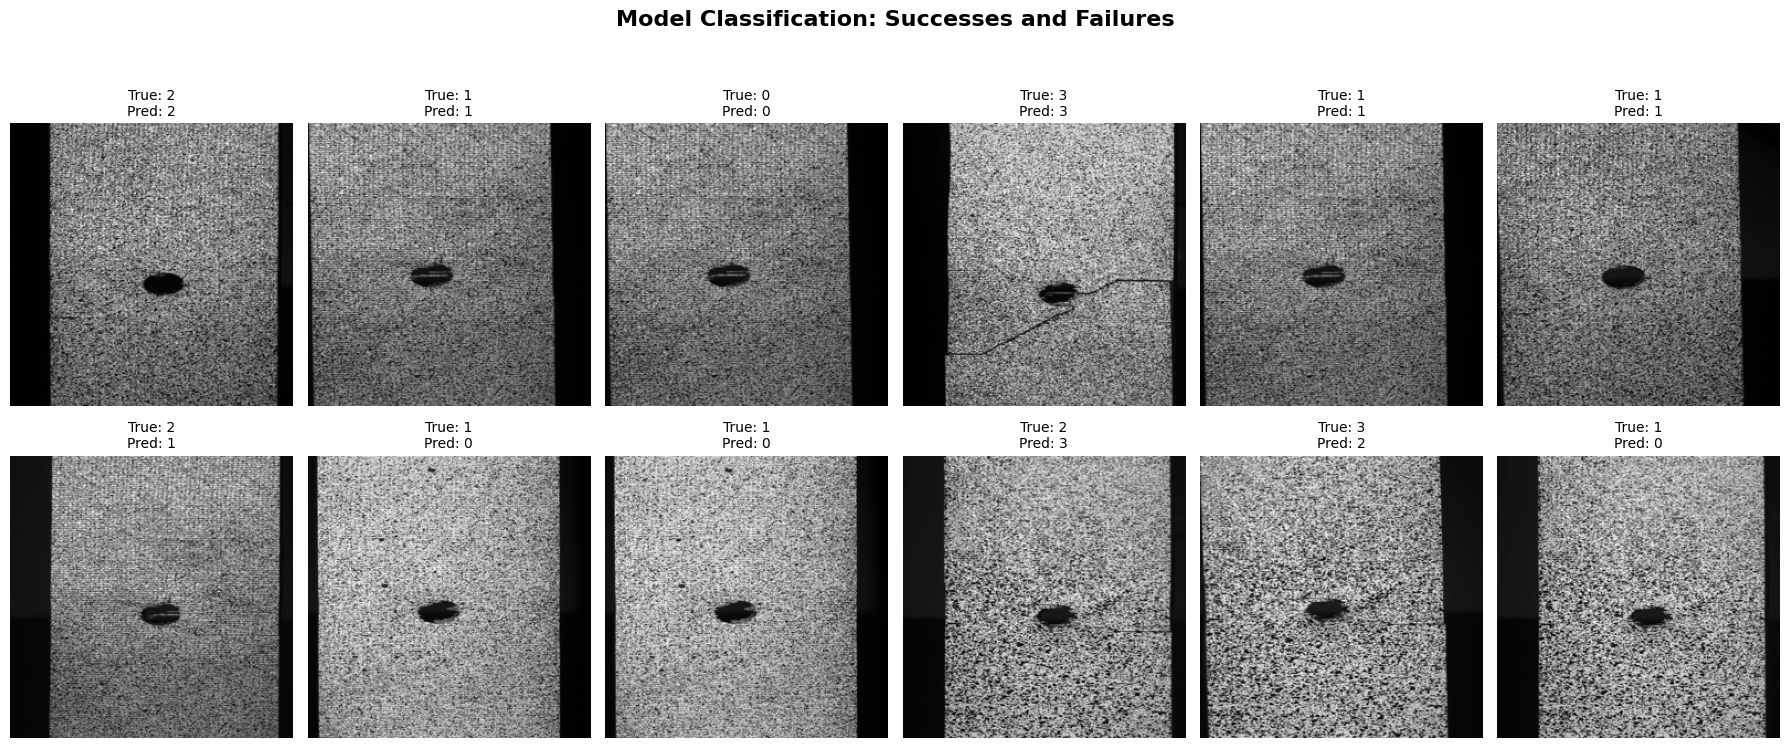

In [9]:
def show_success_failure(model, loader, num_images=6, save_path='success_failure.png'):
    """
    Visualizes examples of successful and failed classifications by the model.

    Args:
        model (nn.Module): Trained PyTorch model for classification.
        loader (DataLoader): DataLoader containing the test or validation dataset.
        num_images (int): Number of examples to display for successes and failures.
        save_path (str): Path to save the resulting visualization.
    """
    model.eval()
    successes = []
    failures = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if preds[i] == labels[i] and len(successes) < num_images:
                    successes.append((images[i].cpu(), labels[i].item(), preds[i].item()))
                elif preds[i] != labels[i] and len(failures) < num_images:
                    failures.append((images[i].cpu(), labels[i].item(), preds[i].item()))
                
                # Break once we have enough examples
                if len(successes) >= num_images and len(failures) >= num_images:
                    break
            if len(successes) >= num_images and len(failures) >= num_images:
                break

    # Create a plot for successes and failures
    fig, axes = plt.subplots(2, num_images, figsize=(18, 8))
    fig.suptitle("Model Classification: Successes and Failures", fontsize=16, weight='bold')

    # Plot success cases
    for i, (image, true_label, pred_label) in enumerate(successes):
        axes[0, i].imshow(image.squeeze(), cmap='gray')
        axes[0, i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        axes[0, i].axis('off')
    axes[0, 0].set_ylabel('Successes', fontsize=14, weight='bold')

    # Plot failure cases
    for i, (image, true_label, pred_label) in enumerate(failures):
        axes[1, i].imshow(image.squeeze(), cmap='gray')
        axes[1, i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        axes[1, i].axis('off')
    axes[1, 0].set_ylabel('Failures', fontsize=14, weight='bold')

    # Optimize layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# Call the function to display success and failure cases
show_success_failure(model, test_loader)
